In [40]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point # generate points 
import xarray as xr
import rioxarray as rio 
import rasterio 
from shapely.geometry import shape
from xrspatial.classify import reclassify #data processing for spatial raster data
from xrspatial.classify import quantile
# Wraps and extends xarray + rasterio. Rasterio is a commonly used package for dealing with geospatial raster data
import matplotlib.pyplot as plt
import hvplot.xarray  # enables .hvplot() for interactive mapping xarray objects
import contextily as cx # add basemap for static map
from scipy.spatial import cKDTree #nearest-neighbor searches in space. >> find k-dimensional neighbours
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

#data path  
wind_speed = xr.open_dataset('/Users/chuaguangwei/Desktop/UCL /UCL - Rey/BEVN 93/Assignment 2/2nd_Assignment-20251029/datasets/wind_speed.nc')
global_airport_path='/Users/chuaguangwei/Desktop/UCL /UCL - Rey/BEVN 93/Assignment 2/MY DATA/airports_clean.geojson'
protected_area_path='/Users/chuaguangwei/Desktop/UCL /UCL - Rey/BEVN 93/Assignment 2/MY DATA/Protected area /UK protected area.shp'
uk_boundary_path='/Users/chuaguangwei/Desktop/UCL /UCL - Rey/BEVN 93/Assignment 2/MY DATA/UK boundary.geojson'
os_names_path = '/Users/chuaguangwei/Desktop/UCL /UCL - Rey/BEVN 93/Assignment 2/MY DATA/opname_gpkg_gb copy 2/Data/opname_gb.gpkg'
water_body_path= '/Users/chuaguangwei/Desktop/UCL /UCL - Rey/BEVN 93/Assignment 2/MY DATA/Water body.shp/b6b92ce3-dcd7-4f0b-8e43-e937ddf1d4eb/data/uklakes_v3_6_poly.gpkg'
land_use_path='/Users/chuaguangwei/Desktop/UCL /UCL - Rey/BEVN 93/Assignment 2/MY DATA/Land use UK/Land use merged 27700.tif'
slope_binary_path = '/Users/chuaguangwei/Desktop/UCL /UCL - Rey/BEVN 93/Assignment 2/MY DATA/UK qgis slope/More than 10degree binary use this.tif'
uk_boundary = gpd.read_file(uk_boundary_path)
#defining the colours
my_cmap = plt.get_cmap('viridis').copy()
my_cmap.set_under('lightgrey')
meter_crs = 'EPSG:27700'
plot_crs = 'EPSG:4326'
viable_color = '#2ca02c'

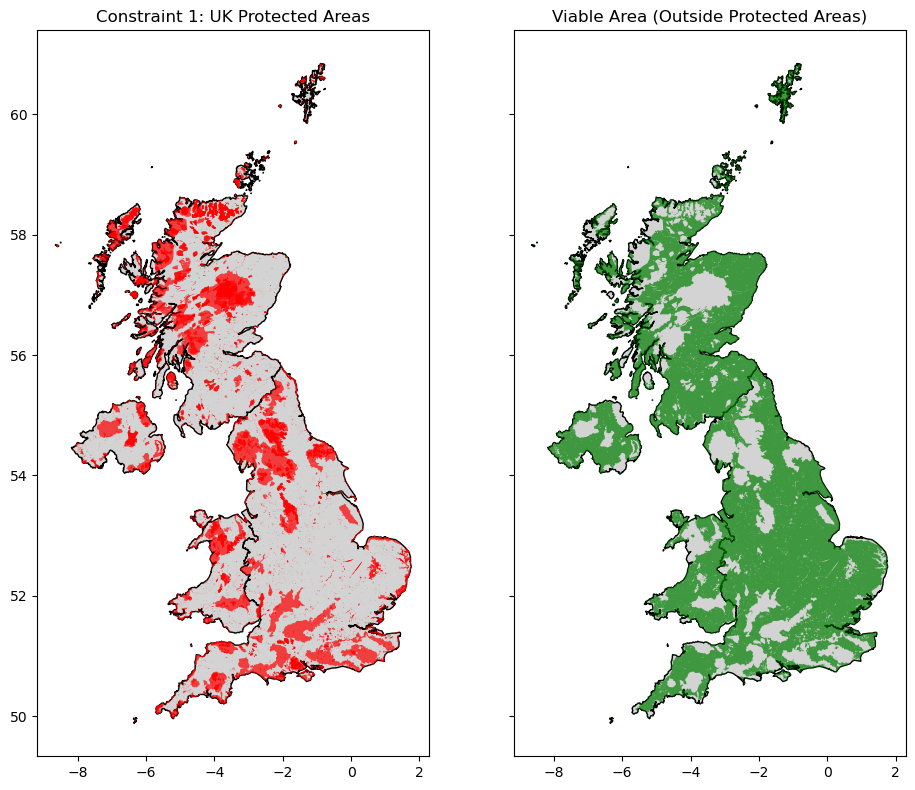

In [10]:
#General Land Constraint

#protected area
uk_boundary = gpd.read_file(uk_boundary_path)
protected_area = gpd.read_file(protected_area_path)


uk_boundary_dissolved = uk_boundary.dissolve()
protected_area_dissolved = protected_area.dissolve()
uk_boundary_meters = uk_boundary_dissolved.to_crs(meter_crs).buffer(0)
protected_area_meters = protected_area_dissolved.to_crs(meter_crs).buffer(0)

protected_viable_area_meters = gpd.overlay(
    gpd.GeoDataFrame(geometry=uk_boundary_meters, crs=meter_crs), 
    gpd.GeoDataFrame(geometry=protected_area_meters, crs=meter_crs), 
    how='difference')

uk_boundary_latlon = uk_boundary.to_crs(plot_crs)
protected_area_latlon = protected_area.to_crs(plot_crs)
protected_viable_area_latlon = protected_viable_area_meters.to_crs(plot_crs)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 8), sharex=True, sharey=True)
#1st
uk_boundary_latlon.plot(ax=ax[0], color='lightgrey', edgecolor='black')
protected_area_latlon.plot(
    ax=ax[0],
    color='red',
    alpha=0.7, # Make it slightly transparent
    legend=True
)
ax[0].set_title('Constraint 1: UK Protected Areas')
#2nd
uk_boundary_latlon.plot(ax=ax[1], color='lightgrey', edgecolor='black')

# Plot the viable "green" area on top
protected_viable_area_latlon.plot(
    ax=ax[1], 
    color='green', 
    alpha=0.7 
)
ax[1].set_title('Viable Area (Outside Protected Areas)')

plt.tight_layout()
plt.show()

/var/folders/sr/qhk7scps7xl0d51nr8bq0r9h0000gn/T/ipykernel_3110/1797688590.py:86: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lightgrey_patch = mpatches.Patch(color='lightgrey', edgecolor='black', label='Constrained Area')


ValueError: 'Upper left' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

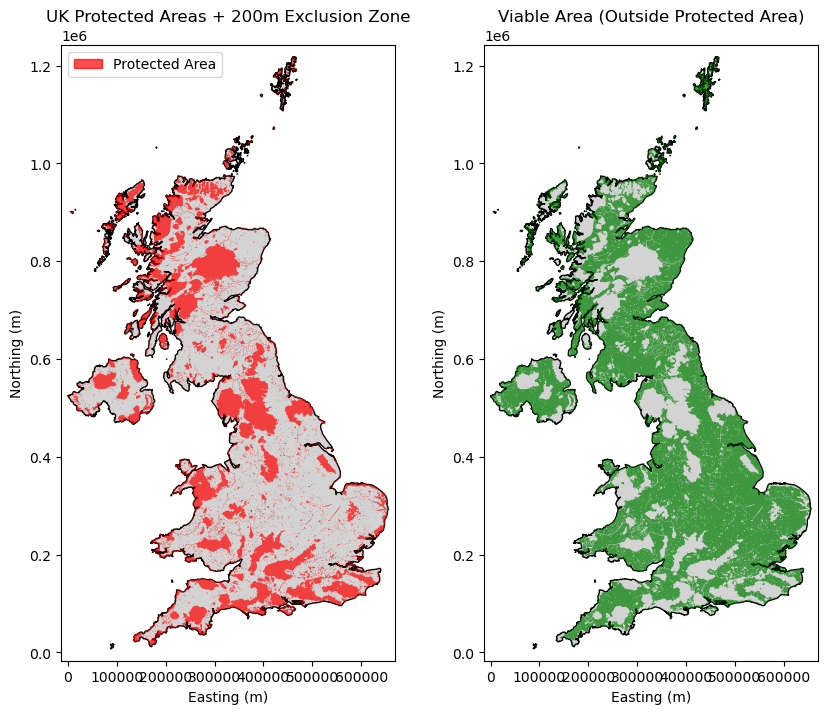

In [25]:
# General Land Constraint

uk_boundary = gpd.read_file(uk_boundary_path)
protected_area = gpd.read_file(protected_area_path)

uk_boundary_dissolved = uk_boundary.dissolve()
protected_area_dissolved = protected_area.dissolve()

# These are the METER CRS variables (EPSG:27700)
uk_boundary_meters = uk_boundary_dissolved.to_crs(meter_crs).buffer(0)
protected_area_meters = protected_area_dissolved.to_crs(meter_crs).buffer(0)

# --- IMPLEMENTING THE 200m BUFFER CONSTRAINT ---
exclusion_buffer_m = 200 # Define the buffer distance from your constraint table
protected_area_exclusion = protected_area_meters.buffer(exclusion_buffer_m) # Apply the 200m buffer

# Calculate the Viable Area: UK boundary MINUS the 200m exclusion zone
protected_viable_area_meters = gpd.overlay(
    gpd.GeoDataFrame(geometry=uk_boundary_meters, crs=meter_crs), 
    gpd.GeoDataFrame(geometry=protected_area_exclusion, crs=meter_crs), 
    how='difference')

# --- PLOTTING IN METER CRS (EPSG:27700) ---

# 1. Define Bounding Box (in meter units)
minx, miny, maxx, maxy = uk_boundary_meters.total_bounds
dx = (maxx - minx) * 0.02
dy = (maxy - miny) * 0.02
bounds = {
    'xlim': (minx - dx, maxx + dx),
    'ylim': (miny - dy, maxy + dy)
}

fig, ax = plt.subplots(1, 2, figsize=(10, 8)) 

# -----------------------------------
# --- Plot 1: Constraints (Meter CRS) ---
# -----------------------------------
ax[0].set_aspect('equal')

# Plot the base boundary (Meter CRS)
uk_boundary_meters.plot(ax=ax[0], color='lightgrey', edgecolor='black')

# Plot the 200m Exclusion Area 
protected_area_exclusion.plot(
    ax=ax[0],
    color='red',
    alpha=0.7)

ax[0].set_xlim(bounds['xlim'])
ax[0].set_ylim(bounds['ylim'])

ax[0].set_title(f'UK Protected Areas + {exclusion_buffer_m}m Exclusion Zone')
ax[0].set_xlabel('Easting (m)')
ax[0].set_ylabel('Northing (m)')

# Define the patch for Plot 1
red_patch = mpatches.Patch(color='red', alpha=0.7, label=f'Protected Area')
ax[0].legend(handles=[red_patch], loc='upper left')


# -----------------------------------
# --- Plot 2: Viable Area (Meter CRS) ---
# -----------------------------------
ax[1].set_aspect('equal')

# Plot the base boundary (Meter CRS)
uk_boundary_meters.plot(ax=ax[1], color='lightgrey', edgecolor='black')

# Plot the viable "green" area (Meter CRS)
protected_viable_area_meters.plot(
    ax=ax[1], 
    color='green', 
    alpha=0.7 
)

ax[1].set_xlim(bounds['xlim'])
ax[1].set_ylim(bounds['ylim'])

ax[1].set_title('Viable Area (Outside Protected Area)')
ax[1].set_xlabel('Easting (m)')
ax[1].set_ylabel('Northing (m)')

# Define the patches for Plot 2
green_patch = mpatches.Patch(color='green', alpha=0.7, label='Remaining Viable Land')
lightgrey_patch = mpatches.Patch(color='lightgrey', edgecolor='black', label='Constrained Area') 
ax[1].legend(handles=[green_patch, lightgrey_patch], loc='Upper left')

plt.tight_layout()
plt.show()

/var/folders/sr/qhk7scps7xl0d51nr8bq0r9h0000gn/T/ipykernel_3110/2235896874.py:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  airport_buffer_geom = uk_airports_meters.buffer(buffer_distance_m).unary_union
/var/folders/sr/qhk7scps7xl0d51nr8bq0r9h0000gn/T/ipykernel_3110/2235896874.py:99: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  constrained_patch = mpatches.Patch(color='lightgrey', edgecolor='black', label='Constrained Area')


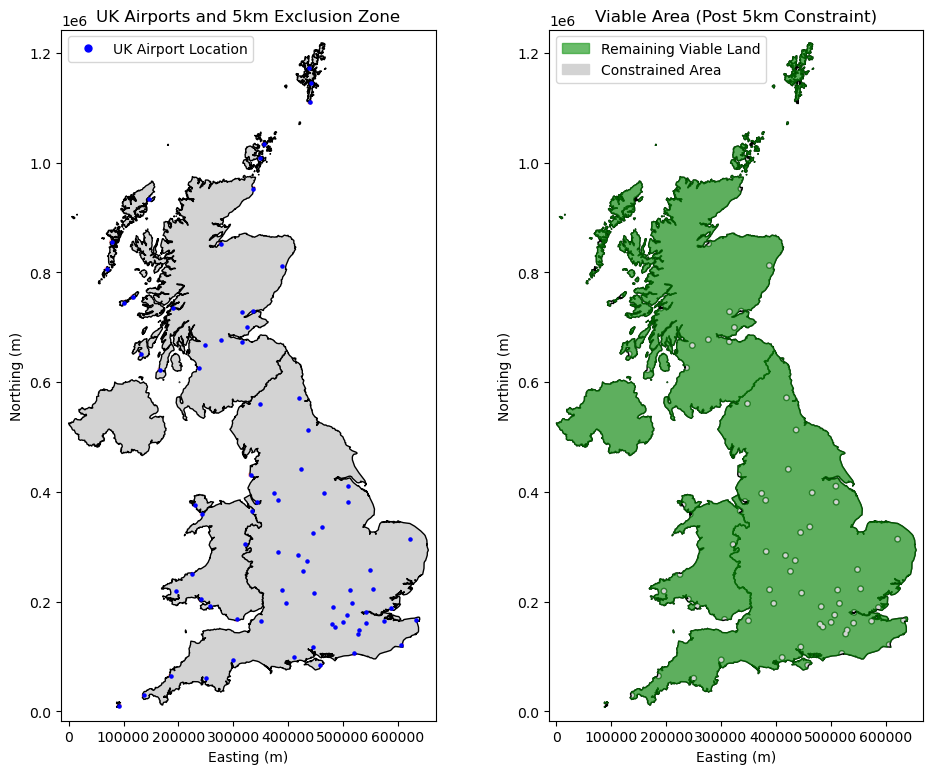

In [43]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

#Insert UK boundaryPath 
#Inser airport file path 
#UK_boundary_path = " " 
#os_names_path= " " 

# Load data and set CRS
uk_boundary_latlon = gpd.read_file(uk_boundary_path)
uk_boundary_latlon = uk_boundary_latlon.to_crs(epsg=4326) 

# Load Airports (in original meters CRS)
uk_airports_meters = gpd.read_file(os_names_path, layer='named_place', where="local_type = 'Airport'")

# Get the meter-based CRS from this file
meter_crs = uk_airports_meters.crs

# Re-project the UK boundary to match the airport's meter-based CRS
uk_boundary_meters = uk_boundary_latlon.to_crs(meter_crs)

# Create 5km Buffer (in METERS)
buffer_distance_m = 5000 # 5km
airport_buffer_geom = uk_airports_meters.buffer(buffer_distance_m).unary_union

# Convert that single geometry into a GeoDataFrame
airport_buffer_meters = gpd.GeoDataFrame(geometry=[airport_buffer_geom], crs=meter_crs)

# The Difference Operation (to find viable area):
airport_viable_area_meters = gpd.overlay(
    uk_boundary_meters, 
    airport_buffer_meters, 
    how='difference')

# --- PLOTTING IN METER CRS (EPSG:27700) ---

# 1. Define Bounding Box (in meter units)
minx, miny, maxx, maxy = uk_boundary_meters.total_bounds
dx = (maxx - minx) * 0.02
dy = (maxy - miny) * 0.02
bounds = {
    'xlim': (minx - dx, maxx + dx),
    'ylim': (miny - dy, maxy + dy)
}

fig, ax = plt.subplots(1, 2, figsize=(10, 8)) 

# plot

ax[0].set_aspect('equal')

airport_buffer_meters.plot(
    ax=ax[0], 
    color='red', 
    alpha=0.3, 
    linewidth=0)
uk_boundary_meters.plot(ax=ax[0], color='lightgrey', edgecolor='black')


uk_airports_meters.plot(ax=ax[0], color='blue', markersize=5)

# Apply Bounding Box
ax[0].set_xlim(bounds['xlim'])
ax[0].set_ylim(bounds['ylim'])

ax[0].set_title(f'UK Airports and {buffer_distance_m/1000:.0f}km Exclusion Zone')
ax[0].set_xlabel('Easting (m)')
ax[0].set_ylabel('Northing (m)')

# --- Legend for Plot 1 (UPPER LEFT) ---
airport_point = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=5, label='UK Airport Location')
ax[0].legend(handles=[airport_point], loc='upper left')


# 2nd plot 
ax[1].set_aspect('equal')

# Plot the base boundary (now represents the excluded areas)
uk_boundary_meters.plot(ax=ax[1], color='lightgrey', edgecolor='black')

# Plot the viable "green" area on top
airport_viable_area_meters.plot(
    ax=ax[1], 
    color='#2ca02c', 
    edgecolor='darkgreen', 
    alpha=0.7 
)

ax[1].set_xlim(bounds['xlim'])
ax[1].set_ylim(bounds['ylim'])

ax[1].set_title(f'Viable Area (Post {buffer_distance_m/1000:.0f}km Constraint)')
ax[1].set_xlabel('Easting (m)')
ax[1].set_ylabel('Northing (m)')

# --- Legend for Plot 2 (UPPER LEFT) ---
viable_patch = mpatches.Patch(color='#2ca02c', alpha=0.7, label='Remaining Viable Land')
constrained_patch = mpatches.Patch(color='lightgrey', edgecolor='black', label='Constrained Area')
ax[1].legend(handles=[viable_patch, constrained_patch], loc='upper left')

plt.tight_layout()
plt.show()

/var/folders/sr/qhk7scps7xl0d51nr8bq0r9h0000gn/T/ipykernel_3110/2278332909.py:61: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  background_patch = mpatches.Patch(color='lightgray', edgecolor='black', label='Base Land Area')
/var/folders/sr/qhk7scps7xl0d51nr8bq0r9h0000gn/T/ipykernel_3110/2278332909.py:87: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  excluded_patch = mpatches.Patch(color='lightgray', edgecolor='black', label='Constrained Area')


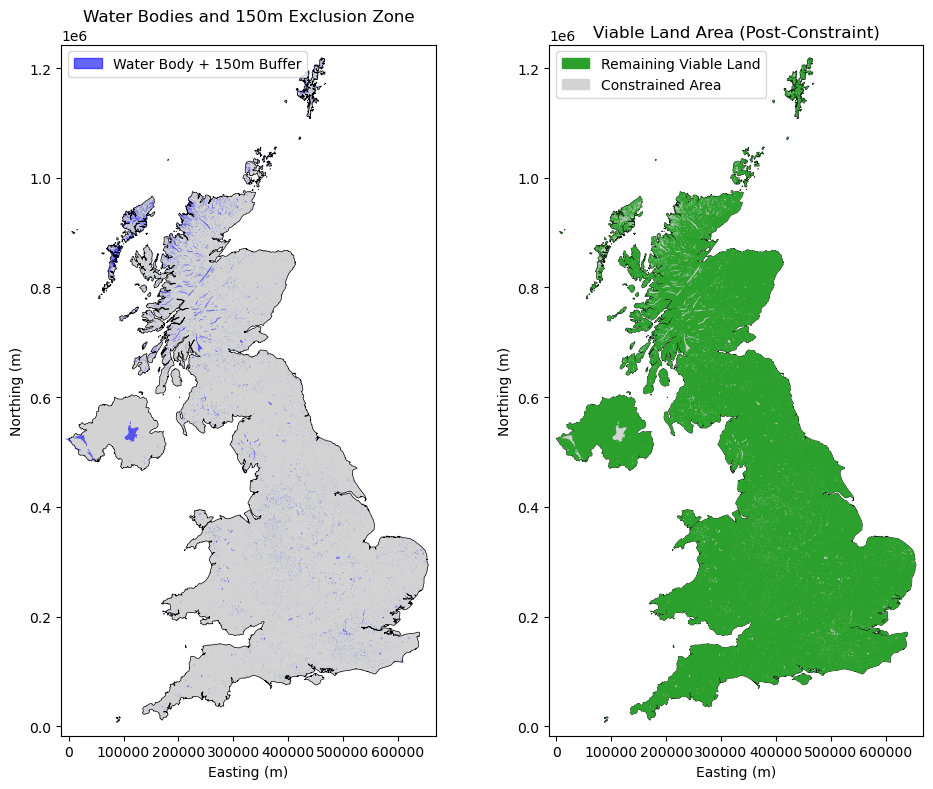

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- Load and Prepare Data ---
# Assuming uk_boundary, water_body_path, and meter_crs are defined

water_body = gpd.read_file(water_body_path, encoding='latin-1')
buffer_distance_m = 150 # Define 150m buffer distance from your constraint table

# Dissolve and re-project to a meter-based CRS for the operation
uk_boundary_proj = uk_boundary.dissolve().to_crs(meter_crs).buffer(0)

# --- APPLY 150m BUFFER CONSTRAINT ---
water_body_proj = water_body.dissolve().to_crs(meter_crs).buffer(buffer_distance_m) # 1. FIX: Apply 150m buffer

# Calculate Viable Land: UK MINUS (Water Bodies + 150m Buffer)
land_minus_water = gpd.overlay(
    gpd.GeoDataFrame(geometry=uk_boundary_proj, crs=meter_crs),
    gpd.GeoDataFrame(geometry=water_body_proj, crs=meter_crs),
    how='difference')

# --- PLOTTING SETUP (Meter CRS) ---
minx, miny, maxx, maxy = uk_boundary_proj.total_bounds
dx = (maxx - minx) * 0.02
dy = (maxy - miny) * 0.02
bounds = {
    'xlim': (minx - dx, maxx + dx),
    'ylim': (miny - dy, maxy + dy)
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

# -----------------------------------
# --- Plot 1: Water Bodies + Buffer ---
# -----------------------------------
ax1.set_aspect('equal')

# Plot the total UK area (will represent the areas not covered by the buffer)
uk_boundary_proj.plot(
    ax=ax1,
    color='lightgray',
    edgecolor='black',
    linewidth=0.5)

# Plot the 150m buffered water bodies (the exclusion zone)
water_body_proj.plot(
    ax=ax1,
    color='blue',
    alpha=0.6,
    edgecolor='none')

ax1.set_xlim(bounds['xlim'])
ax1.set_ylim(bounds['ylim'])
ax1.set_title(f'Water Bodies and {buffer_distance_m}m Exclusion Zone')
ax1.set_xlabel('Easting (m)')
ax1.set_ylabel('Northing (m)')

# --- Legend for Plot 1 (Top Left) ---
water_patch = mpatches.Patch(color='blue', alpha=0.6, label=f'Water Body + {buffer_distance_m}m Buffer')
background_patch = mpatches.Patch(color='lightgray', edgecolor='black', label='Base Land Area')
ax1.legend(handles=[water_patch], loc='upper left')

# -----------------------------------
# --- Plot 2: Viable Land Area ---
# -----------------------------------
ax2.set_aspect('equal')

# Plot the total UK area (will represent the excluded areas)
uk_boundary_proj.plot(
    ax=ax2,
    color='lightgray',
    edgecolor='black',
    linewidth=0.5)

# Plot the "difference" result (Viable Land)
land_minus_water.plot(ax=ax2, color='#2ca02c', edgecolor='none')

ax2.set_xlim(bounds['xlim'])
ax2.set_ylim(bounds['ylim'])
ax2.set_title('Viable Land Area (Post-Constraint)')
ax2.set_xlabel('Easting (m)')
ax2.set_ylabel('Northing (m)')

# --- Legend for Plot 2 (Top Left) ---
viable_patch = mpatches.Patch(color='#2ca02c', label='Remaining Viable Land')
excluded_patch = mpatches.Patch(color='lightgray', edgecolor='black', label='Constrained Area')
ax2.legend(handles=[viable_patch, excluded_patch], loc='upper left')

plt.tight_layout()
plt.show()

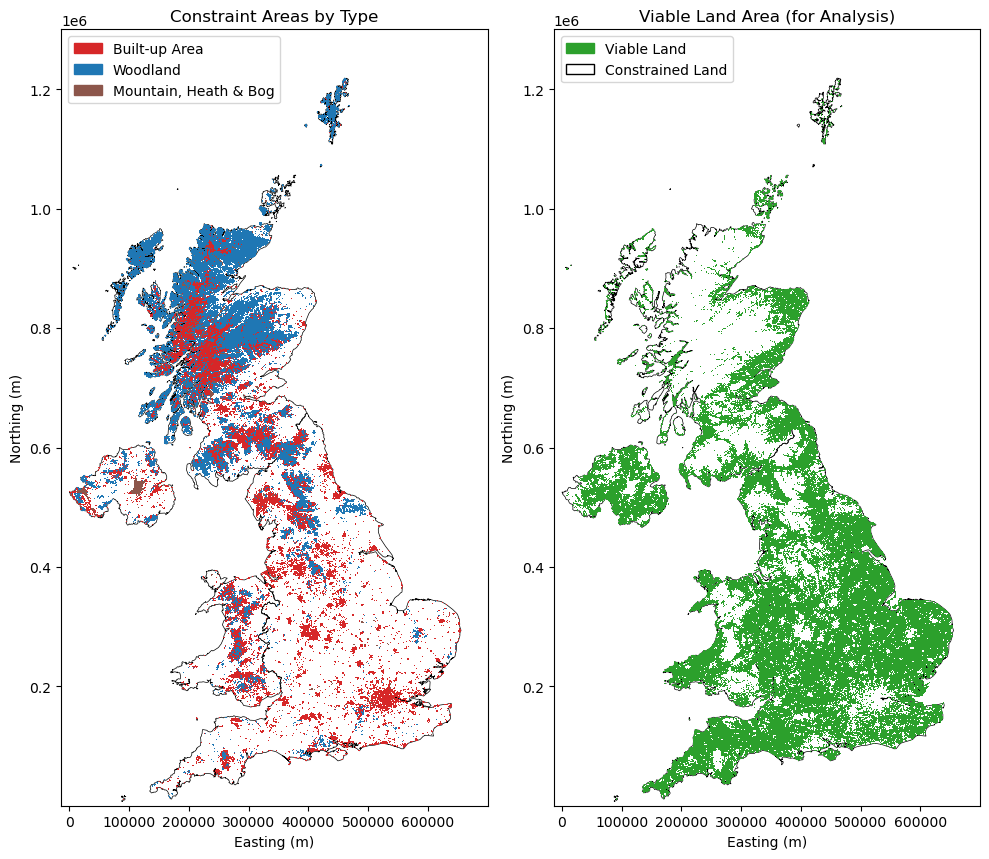

In [32]:
#land use
data_array = rio.open_rasterio(land_use_path).squeeze(drop=True)
uk_boundary_plot = uk_boundary.to_crs(meter_crs) 
constrained_bg_color = 'white'

viable_classes = [3, 4, 7] # Arable, Improved Grass, Semi-natural Grass

viable_land = data_array.isin(viable_classes)
viable_plot = data_array.where(viable_land)

# Create separate visualization layers (for Plot 1)
built_up_plot = data_array.where(data_array.isin([5, 10])) # Urban/Suburban
woodland_plot = data_array.where(data_array.isin([2, 6]))  # Woodlands
bog_heath_plot = data_array.where(data_array == 8)          # Mtn/Heath/Bog

# Define colors
viable_color = '#2ca02c'
built_up_color = '#d62728' # Red
woodland_color = '#1f77b4' # Blue
bog_heath_color = '#8c564b' # Brown

#prepare legend
legend_patches_ax1 = [
    mpatches.Patch(color=built_up_color, label='Built-up Area'),
    mpatches.Patch(color=woodland_color, label='Woodland'),
    mpatches.Patch(color=bog_heath_color, label='Mountain, Heath & Bog')
]
legend_patch_ax2 = [
    mpatches.Patch(color=viable_color, label='Viable Land'),
    mpatches.Patch(facecolor='white', edgecolor='black', label='Constrained Land') # Changed here
]

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

#plot 1
ax1.set_aspect('equal')
uk_boundary_plot.plot(ax=ax1, color='none', edgecolor='black', linewidth=0.5)

# Plot each constraint layer on top of each other
built_up_plot.plot(ax=ax1, cmap=mcolors.ListedColormap([built_up_color]), add_colorbar=False)
woodland_plot.plot(ax=ax1, cmap=mcolors.ListedColormap([woodland_color]), add_colorbar=False)
bog_heath_plot.plot(ax=ax1, cmap=mcolors.ListedColormap([bog_heath_color]), add_colorbar=False)

ax1.set_title('Constraint Areas by Type')
ax1.set_xlabel("Easting (m)")
ax1.set_ylabel("Northing (m)")
ax1.legend(handles=legend_patches_ax1, loc='upper left')

# plot 2
ax2.set_aspect('equal')
uk_boundary_plot.plot(ax=ax2, color='none', edgecolor='black', linewidth=0.5)

viable_plot.plot(ax=ax2, cmap=mcolors.ListedColormap([viable_color]), add_colorbar=False)

ax2.set_title('Viable Land Area (for Analysis)')
ax2.set_xlabel("Easting (m)")
ax2.set_ylabel("Northing (m)")
ax2.legend(handles=legend_patch_ax2, loc='upper left')

plt.tight_layout()
plt.show()

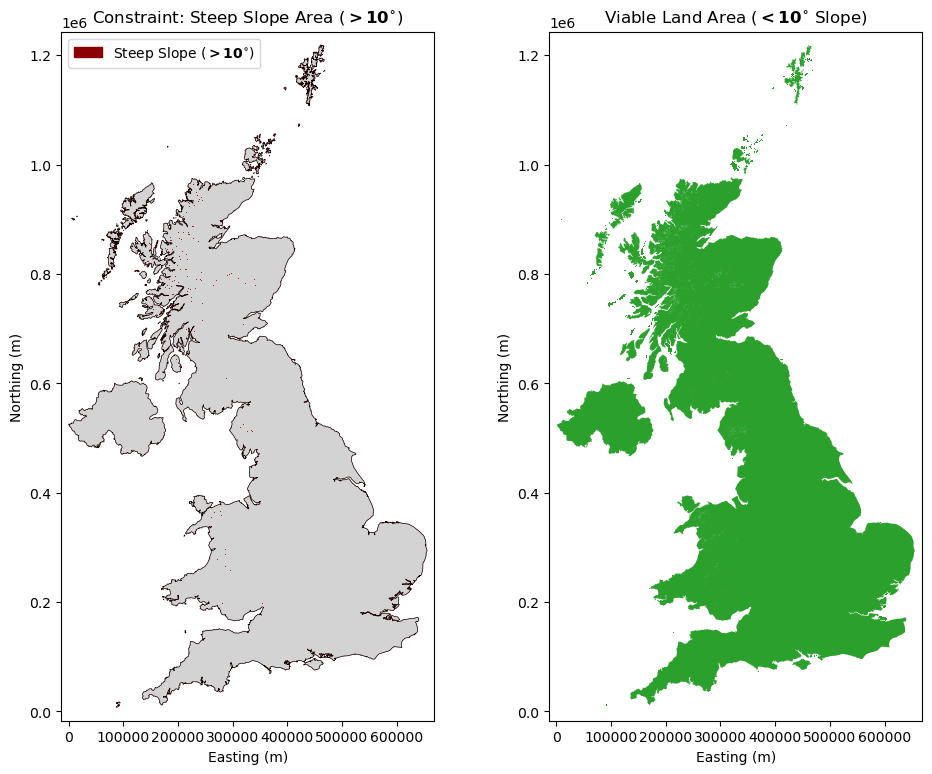

In [41]:
# --- 1. Load and Prepare Data ---
uk_boundary = gpd.read_file(uk_boundary_path, encoding='latin-1')
# uk_boundary_proj is a GeoSeries (requires conversion later)
uk_boundary_proj = uk_boundary.dissolve().to_crs(meter_crs).buffer(0) 

# Load the raster data for plotting (ax1) and conversion (ax2)
slope_binary = rio.open_rasterio(slope_binary_path).squeeze(drop=True)

# Define a custom colormap for the binary raster (1=Steep, 0=Safe)
cmap_binary = mcolors.ListedColormap(['#FFFFE0', 'darkred']) 
bounds = [0, 0.5, 1] 
norm = mcolors.BoundaryNorm(bounds, cmap_binary.N)

# --- 2. Convert Steep Slope Raster (Value=1) to Vector (for difference calculation) ---

with rasterio.open(slope_binary_path) as src:
    image = src.read(1)
    transform = src.transform

steep_slope_geometries = []
for geom, value in shapes(image, transform=transform):
    if value == 1:
        shapely_geom = shape(geom) 
        steep_slope_geometries.append(shapely_geom) 

# steep_slope_gdf is a GeoSeries (requires conversion later)
num_features = len(steep_slope_geometries)
steep_slope_gs = gpd.GeoDataFrame(
    {'slope_type': [1] * num_features}, 
    geometry=steep_slope_geometries,
    crs=meter_crs
).dissolve().buffer(0) 

# --- 3. Perform the Difference Operation (FIXING GeoSeries to GeoDataFrame Error) ---

# Convert the two GeoSeries objects back into GeoDataFrames for overlay
uk_boundary_gpdf = gpd.GeoDataFrame(geometry=uk_boundary_proj, crs=meter_crs)
steep_slope_gpdf = gpd.GeoDataFrame(geometry=steep_slope_gs, crs=meter_crs) 

# Subtract the steep slope area from the initial UK boundary area
viable_land_safe_slope = gpd.overlay(
    uk_boundary_gpdf,     # GeoDataFrame
    steep_slope_gpdf,     # GeoDataFrame
    how='difference'
)

# --- 4. Plotting the Results ---

# Define a Consistent Bounding Box (in meter_crs units)
minx, miny, maxx, maxy = uk_boundary_gpdf.total_bounds
dx = (maxx - minx) * 0.02
dy = (maxy - miny) * 0.02
bounds = {
    'xlim': (minx - dx, maxx + dx),
    'ylim': (miny - dy, maxy + dy)
}

# Define legend patches for Plot 1
legend_patches_ax1 = [
    mpatches.Patch(color='darkred', label=r'Steep Slope ($\bf{>10^{\circ}}$)')
]
#plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.set_aspect('equal')

# Plot the base boundary (GeoDataFrame)
uk_boundary_gpdf.plot(
    ax=ax1, 
    color='lightgray', 
    edgecolor='black', 
    linewidth=0.5)

# Plot the steep slope constraint (GeoDataFrame)
steep_slope_gpdf.plot(
    ax=ax1, 
    color='darkred', 
    edgecolor='none', 
    alpha=0.8)

# Apply Bounding Box
ax1.set_xlim(bounds['xlim'])
ax1.set_ylim(bounds['ylim'])

ax1.set_title(r'Constraint: Steep Slope Area ($\bf{>10^{\circ}}$)')
ax1.set_xlabel("Easting (m)")
ax1.set_ylabel("Northing (m)")
ax1.legend(handles=legend_patches_ax1, loc='upper left')

ax2.set_aspect('equal')

# Plot the "difference" result (Viable Land)
viable_land_safe_slope.plot(ax=ax2, color=viable_color, edgecolor='none')

# Apply Bounding Box (Identical to ax1)
ax2.set_xlim(bounds['xlim'])
ax2.set_ylim(bounds['ylim'])

ax2.set_title(r'Viable Land Area ($\bf{<10^{\circ}}$ Slope)')
ax2.set_xlabel('Easting (m)')
ax2.set_ylabel('Northing (m)')

plt.tight_layout()
plt.show()

protected_viable_area_latlon
airport_viable_area_latlon
land_minus_water
viable_plot
viable_land_safe_slope

/var/folders/sr/qhk7scps7xl0d51nr8bq0r9h0000gn/T/ipykernel_3110/2748254490.py:85: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color='lightgray', edgecolor='black', label='Excluded Area')


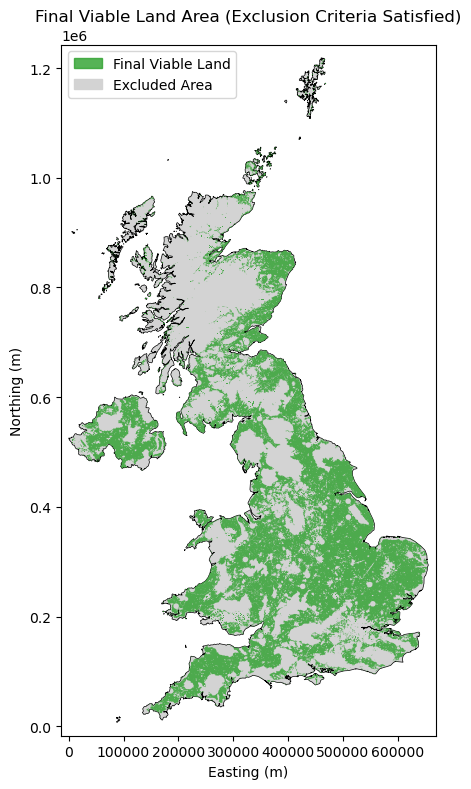

In [47]:
viable_step_1 = gpd.overlay(
    viable_slope_meters,
    viable_water_meters,
    how='intersection'
)

# B. Intersect result with Airport constraint
viable_step_2 = gpd.overlay(
    viable_step_1,
    viable_airport_meters,
    how='intersection'
)

# C. Intersect result with Protected Area constraint (This is the required variable!)
viable_step_3 = gpd.overlay(
    viable_step_2,
    viable_protected_meters,
    how='intersection'
)


# --- 2. Land Use: Raster-to-Vector Conversion ---
# This section remains largely the same, but we ensure numpy is imported.

viable_classes = [3, 4, 7]
with rasterio.open(land_use_path) as src:
    # Read the data and transform
    image_data = src.read(1)
    transform = src.transform

# Create a binary mask: 1 where the land use is viable, 0 otherwise
# np.isin requires numpy
landuse_mask = np.isin(image_data, viable_classes)

# Generate vector features (polygons) only for the viable areas (value = 1)
landuse_geometries = []
# Use the mask to polygonize the "True" (1) values
for geom, value in shapes(landuse_mask.astype(np.int16), mask=None, transform=transform):
    if value == 1: 
        landuse_geometries.append(shape(geom))
# Calculate the number of geometries to fix the scalar value problem
num_features = len(landuse_geometries)

initial_landuse_gdf = gpd.GeoDataFrame(
    {'suitability': [1] * num_features}, 
    geometry=landuse_geometries,
    crs=meter_crs
).dissolve() # Dissolve here to create a single geometry collection

# Final Conversion to GeoDataFrame (Get the single geometry)
clean_landuse_geometry = initial_landuse_gdf.iloc[0].geometry # Get the single complex geometry

# Convert the single Shapely geometry object back into a robust GeoDataFrame.
viable_landuse_gpdf = gpd.GeoDataFrame(
    geometry=[clean_landuse_geometry],
    crs=meter_crs
)

# --- 3. Final Intersection (Intersecting viable_step_3 with Land Use) ---

# Define the bounding box variables for plotting (moved up for use in plotting setup)
minx, miny, maxx, maxy = uk_boundary_gpdf.total_bounds
dx = (maxx - minx) * 0.02
dy = (maxy - miny) * 0.02
bounds = {
    'xlim': (minx - dx, maxx + dx),
    'ylim': (miny - dy, maxy + dy)
}

# FINAL OVERLAY: Intersect result of 4 vector constraints (viable_step_3) with 
# the 5th (Land Use) constraint.
total_viable_area = gpd.overlay(
    viable_step_3,             
    viable_landuse_gpdf,       
    how='intersection'
)

# --- 4. Plotting the Result ---

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Define Legend Patches
legend_patches = [
    mpatches.Patch(color=viable_color, alpha=0.8, label='Final Viable Land'),
    mpatches.Patch(color='lightgray', edgecolor='black', label='Excluded Area')
]

ax.set_aspect('equal')

# 1. Plot the base boundary for context (in meter CRS)
uk_boundary_gpdf.plot(
    ax=ax, 
    color='lightgray', 
    edgecolor='black', 
    linewidth=0.5
)

# 2. Plot the Total Viable Area on top (The final result)
total_viable_area.plot(
    ax=ax, 
    color=viable_color, 
    edgecolor='none', 
    alpha=0.8
)

# 3. Apply Bounding Box
ax.set_xlim(bounds['xlim'])
ax.set_ylim(bounds['ylim'])

# 4. Set Title, Axes, and Legend
ax.set_title(r'Final Viable Land Area (Exclusion Criteria Satisfied)')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.legend(handles=legend_patches, loc='upper left')

plt.tight_layout()
plt.show()

In [46]:

# Calculate the number of geometries to fix the scalar value problem
num_features = len(landuse_geometries)

initial_landuse_gdf = gpd.GeoDataFrame(
    {'suitability': [1] * num_features}, 
    geometry=landuse_geometries,
    crs=meter_crs)

clean_landuse_geometry = initial_landuse_gdf.dissolve().buffer(0).iloc[0] 

#  Final Conversion to GeoDataFrame (The necessary GeoDataFrame for overlay)

# Convert the single Shapely geometry object back into a robust GeoDataFrame.
# We pass the geometry inside a list ([...]) to define the single row.
viable_landuse_gpdf = gpd.GeoDataFrame(
    geometry=[clean_landuse_geometry],
    crs=meter_crs
)
viable_step_1 = gpd.overlay(
    viable_slope_meters,
    viable_water_meters,
    how='intersection'
)

# B. Intersect result with Airport constraint
viable_step_2 = gpd.overlay(
    viable_step_1,
    viable_airport_meters,
    how='intersection'
)

# C. Intersect result with Protected Area constraint (This is the required variable!)
viable_step_3 = gpd.overlay(
    viable_step_2,
    viable_protected_meters,
    how='intersection'
)


NameError: name 'viable_step_3' is not defined

NameError: name 'total_viable_area' is not defined

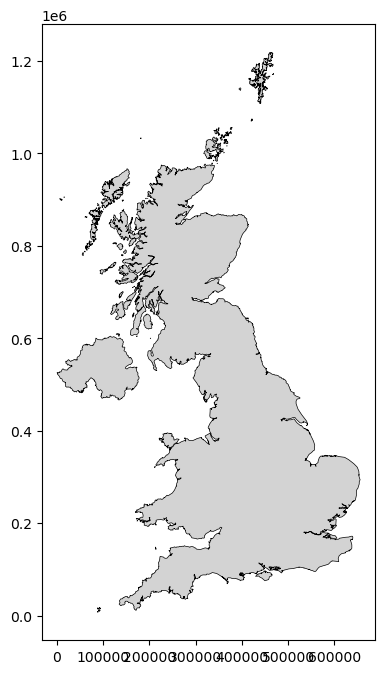

In [45]:
minx, miny, maxx, maxy = uk_boundary_gpdf.total_bounds
dx = (maxx - minx) * 0.02
dy = (maxy - miny) * 0.02
bounds = {
    'xlim': (minx - dx, maxx + dx),
    'ylim': (miny - dy, maxy + dy)
}
viable_color = '#2ca02c' # Green for Viable Area

# --- 3. Plotting the Result ---

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_aspect('equal')

# 1. Plot the base boundary for context (in meter CRS)
uk_boundary_gpdf.plot(
    ax=ax, 
    color='lightgray', 
    edgecolor='black', 
    linewidth=0.5
)

# 2. Plot the Total Viable Area on top (The final result)
total_viable_area.plot(
    ax=ax, 
    color=viable_color, 
    edgecolor='none', 
    alpha=0.8
)

# 3. Apply Bounding Box
ax.set_xlim(bounds['xlim'])
ax.set_ylim(bounds['ylim'])

# 4. Set Title and Axes
ax.set_title(r'Final Viable Land Area (Exclusion Criteria Satisfied)')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

plt.tight_layout()
plt.show()

In [65]:
# Corrected code to save the GeoPackage
total_viable_area.to_file(
    '/Users/chuaguangwei/Desktop/UCL /UCL - Rey/BEVN 93/Assignment 2/final_total_viable_area.gpkg',  
    driver='GPKG',
    GEOMETRY_NAME='geom' # Keep this for robustness
)

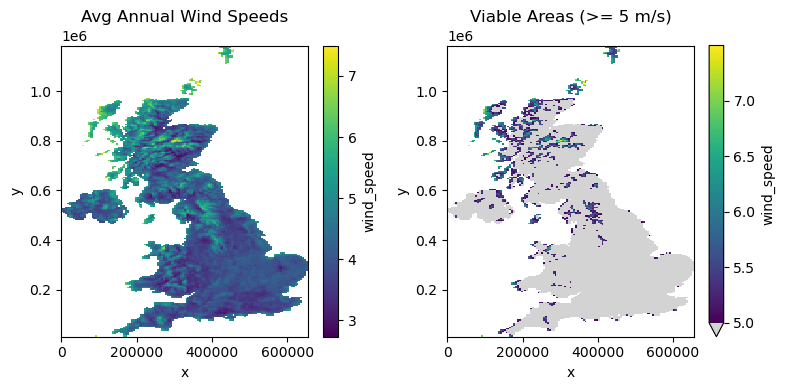

In [59]:
#Wind speed 
wind_speed.season
wind_speed= wind_speed.rio.write_crs(4326)
wind_speed.rio.crs
annual_avg_wind_speed = wind_speed['wind_speed'].mean(dim='season')

#binning for discrete legend
bin_edges = [0, 5, 8, 14]
binned_data = xr.where(annual_avg_wind_speed <= 5, '0-5 m/s (Low)',xr.where(annual_avg_wind_speed <= 8, '5-8 m/s (Medium)','>8 m/s (High)'))

#plotting transition dropping wind speed of <5m/s
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

annual_avg_wind_speed.plot(ax=ax[0],cmap='viridis',add_colorbar=True)
ax[0].set_title('Avg Annual Wind Speeds')

annual_avg_wind_speed.plot(ax=ax[1],cmap=my_cmap,vmin=5,extend='min') #means <5m/s will be greyed
ax[1].set_title('Viable Areas (>= 5 m/s)')

plt.tight_layout()
plt.show()

In [64]:
wind_speed.rio.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

UsageError: Cell magic `%%mermaid` not found.
